# Figure 7 (Panels B and C)

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
import pandas as pd
import h5py
import sys
import os
# from directory_paths import SAVE_DIR, PARENT_DIR

SAVE_DIR = "/media/data/merkourios"
DATA_DIR = os.path.join(SAVE_DIR, "data_for_figs")

In [10]:
MUSCLE_NAMES = [
    "CORB",
    "DELT1",
    "DELT2",
    "DELT3",
    "INFSP",
    "LAT1",
    "LAT2",
    "LAT3",
    "PECM1",
    "PECM2",
    "PECM3",
    "SUBSC",
    "SUPSP",
    "TMAJ",
    "TMIN",
    "ANC",
    "BIClong",
    "BICshort",
    "BRA",
    "BRD",
    "ECRL",
    "PT",
    "TRIlat",
    "TRIlong",
    "TRImed",
]

ELBOW_ANGLE_INDEX = 6

In [11]:
def load_data(path, verbose=True, index_end=None):
    with h5py.File(path, "r") as f:
        if verbose:
            print("Keys: %s" % f.keys())
            for key in f.keys():
                print(f"Key {key} has shape {f[key].shape}")
    with h5py.File(path, "r") as f:
        if verbose:
            print(f"Loading the first {index_end} samples")
        if index_end is not None:
            data = f["data"][:index_end]
            labels = f["labels"][:index_end]
        else:
            data = f["data"][:]
            labels = f["labels"][:]
    return data, labels

def compute_correlation(data, labels, muscle_names, elbow_angle_index):
    from scipy.stats import pearsonr
    correlation = {}
    for muscle_index, muscle_name in enumerate(muscle_names):
        r = []
        for i in range(data.shape[1]):
            muscle_activations = data[:, i, muscle_index].flatten()
            elbow_angles = labels[:, :, elbow_angle_index].flatten()

            # Remove values where the elbow angle is 130
            # mask = elbow_angles != 130
            # muscle_activations = muscle_activations[mask]
            # elbow_angles = elbow_angles[mask]

            r.append(pearsonr(muscle_activations, elbow_angles)[0])
        correlation[muscle_name] = r

        # Transform into a pandas DataFrame
        df = pd.DataFrame(correlation)
        # Add spindle index as a column
        df["spindle"] = np.arange(1, len(correlation[muscle_name]) + 1)
    return correlation, df


def plot_correlation_from_dict(correlation, muscle_names):
    # Violin plot of the correlation between muscle activations and elbow angle
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.violinplot([correlation[muscle_name] for muscle_name in muscle_names])
    # Also plot the individual points
    for i, muscle_name in enumerate(muscle_names):
        x = np.random.normal(i + 1, 0.04, size=len(correlation[muscle_name]))
        ax.scatter(x, correlation[muscle_name], alpha=0.2)
    ax.set_xticks(np.arange(1, len(muscle_names) + 1))
    ax.set_xticklabels(muscle_names, rotation=90)
    # Set TRI muscles to green
    for i in range(22, 25):
        ax.get_xticklabels()[i].set_color("green")
    # Set BIC muscles to red
    for i in range(16, 18):
        ax.get_xticklabels()[i].set_color("red")
    # Horizontal line at 0
    ax.axhline(0, color="black", linestyle="--", linewidth=0.5)
    plt.title("Correlation between muscle activations and elbow angle")
    return fig, ax

COLORMAP = {
    "CORB": "gray",
    "DELT1": "gray",
    "DELT2": "gray",
    "DELT3": "gray",
    "INFSP": "gray",
    "LAT1": "gray",
    "LAT2": "gray",
    "LAT3": "gray",
    "PECM1": "gray",
    "PECM2": "gray",
    "PECM3": "gray",
    "SUBSC": "gray",
    "SUPSP": "gray",
    "TMAJ": "gray",
    "TMIN": "gray",
    "ANC": "blue",
    "BIClong": "red",
    "BICshort": "red",
    "BRA": "red",
    "BRD": "red",
    "ECRL": "red",
    "PT": "red",
    "TRIlat": "blue",
    "TRIlong": "blue",
    "TRImed": "blue",
}

def plot_correlation_from_df(correlation_df, muscle_names):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    # Drop columns 'seed' and 'spindle'
    correlation_df = correlation_df.drop(columns=["seed", "spindle"])
    # Find the order of the muscles from least to most correlated
    order = correlation_df.mean().sort_values().index
    for i, muscle_name in enumerate(order):
        x = np.random.normal(i + 1, 0.04, size=len(correlation_df[muscle_name]))
        ax.scatter(x, correlation_df[muscle_name], alpha=0.2, color=COLORMAP[muscle_name])
    # for i, muscle_name in enumerate(muscle_names):
    #     x = np.random.normal(i + 1, 0.04, size=len(correlation_df[muscle_name]))
    #     ax.scatter(x, correlation_df[muscle_name], alpha=0.2)
    ax.set_xticks(np.arange(1, len(muscle_names) + 1))
    ax.set_xticklabels(order, rotation=90)
    # Set tick labels to the color of the muscles
    for i, muscle_name in enumerate(order):
        ax.get_xticklabels()[i].set_color(COLORMAP[muscle_name])
    # Horizontal line at 0
    ax.axhline(0, color="black", linestyle="--", linewidth=0.5)
    plt.title("Correlation between muscle activations and elbow angle")
    return fig, ax

In [12]:
# combined_df = pd.DataFrame()

# for seed in range(5):
#     for data_path in [
#         os.path.join(SAVE_DIR, f"optimized_linear_extended_{seed}_5_5_flag_pcr_test_dec_16_240Hz_cleaned_smoothed.hdf5"),
#         os.path.join(SAVE_DIR, f"optimized_linear_extended_{seed}_5_5_flag_pcr_training_240Hz_30k_cleaned_smoothed.hdf5"),
#         os.path.join(SAVE_DIR, f"optimized_linear_extended_{seed}_5_5_elbow_flex_20_smoothed_cleaned.hdf5"),
#         os.path.join(SAVE_DIR, f"optimized_linear_extended_{seed}_5_5_elbow_flex_visualize_flat_100_240Hz.hdf5"),
#     ]:
#         if "flag_pcr_test" in data_path:
#             key = "flag_pcr_test"
#         elif "flag_pcr_training" in data_path:
#             key = "flag_pcr_train"
#         elif "elbow_flex_20" in data_path:
#             key = "elbow_flex"
#         elif "elbow_flex_visualize" in data_path:
#             key = "elbow_static"

#         print(f"Processing {data_path}")
#         data, labels = load_data(data_path)
#         correlation, df = compute_correlation(data, labels, MUSCLE_NAMES, ELBOW_ANGLE_INDEX)

#         df["seed"] = seed
#         df["dataset"] = key
#         combined_df = pd.concat([combined_df, df])

#         print(combined_df.tail(10))

# combined_df.to_csv(os.path.join(SAVE_DIR, "fr_elbow_angle_correlation_all_datasets.csv"), index=False)

combined_df = pd.read_csv(os.path.join(DATA_DIR, "fr_elbow_angle_correlation_all_datasets.csv"))
combined_df.head(10)

,CORB,DELT1,DELT2,DELT3,INFSP,LAT1,LAT2,LAT3,PECM1,PECM2,...,BRA,BRD,ECRL,PT,TRIlat,TRIlong,TRImed,spindle,seed,dataset
0,0.088377,0.084108,0.011585,-0.121352,-0.209624,0.043480,0.016145,0.048477,-0.021947,-0.016072,...,0.008417,-0.214736,-0.123863,-0.457933,-0.066042,-0.032295,0.245650,1,0,flag_pcr_test
1,0.088770,0.072301,0.027315,-0.133945,-0.200719,0.017009,0.018695,0.036343,0.098017,0.045293,...,-0.060895,-0.235069,0.105566,-0.254558,0.033182,-0.029890,0.229192,2,0,flag_pcr_test
2,0.085386,0.064189,0.024171,-0.039593,-0.074156,0.036827,0.034201,0.000972,0.050065,0.044601,...,-0.106321,0.075586,-0.053436,-0.327788,0.333077,0.023068,0.212349,3,0,flag_pcr_test
3,0.028614,0.078528,0.010365,-0.152715,-0.242499,0.049386,0.013667,0.029290,0.126038,0.044673,...,-0.152283,0.047634,0.119019,-0.008975,0.127658,0.389546,-0.039187,4,0,flag_pcr_test
4,0.088878,0.052850,0.017000,-0.113335,-0.231002,0.030768,0.028637,0.023091,0.067453,0.005104,...,-0.289552,-0.438689,-0.124092,-0.426548,-0.005945,-0.051108,0.306270,5,0,flag_pcr_test
5,0.069430,0.096251,0.047041,-0.144281,-0.240106,-0.013291,0.007683,0.014250,0.128290,0.024846,...,-0.315580,-0.077385,-0.242815,-0.174488,0.394706,0.227173,0.059680,6,0,flag_pcr_test
6,0.067514,0.095102,0.056609,-0.162751,-0.179533,-0.014598,-0.012080,0.008426,0.115346,0.047356,...,-0.355327,-0.061357,-0.314493,-0.324150,0.322774,0.221220,0.102235,7,0,flag_pcr_test
7,0.005686,0.052851,0.044422,-0.127777,-0.028184,0.024997,-0.001310,-0.013382,0.023980,0.028607,...,-0.002730,-0.320398,-0.121927,-0.152491,0.198247,0.076059,0.122874,8,0,flag_pcr_test
8,0.073233,0.052991,0.025919,-0.145401,-0.049936,-0.001437,0.000394,0.001260,0.126495,0.020049,...,-0.440939,-0.033208,-0.161556,-0.288095,0.219090,0.147513,0.219621,9,0,flag_pcr_test
9,0.088574,0.111824,0.050300,-0.044466,-0.223681,0.005195,-0.000368,0.011791,0.137384,0.025049,...,-0.022266,-0.093437,-0.155730,-0.448589,0.467089,0.282837,0.421769,10,0,flag_pcr_test


/media/data/merkourios/tmp/ipykernel_1851690/3048562294.py:98: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  order = correlation_df.mean().sort_values().index


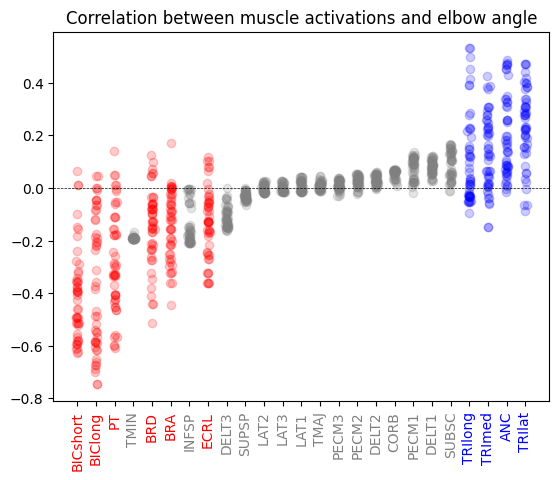

In [13]:
import matplotlib.pyplot as plt

dataset = 'flag_pcr_train'
fig, ax = plot_correlation_from_df(combined_df[combined_df['dataset'] == dataset], MUSCLE_NAMES)
plt.show()

In [14]:
# Make a new dataframe with the following columns: dataset, seed, {muscle_name}_mean
correlation_df_mean = combined_df.groupby(["dataset", "seed"]).mean().reset_index()
correlation_df_mean.drop(columns=["spindle"], inplace=True)
# Pivot the dataframe so that there is one column for all the muscle names and one column for the correlation
correlation_df_mean = correlation_df_mean.melt(id_vars=["dataset", "seed"], var_name="muscle", value_name="correlation")

# Example query
correlation_df_mean[(correlation_df_mean["dataset"] == dataset) & (correlation_df_mean["muscle"] == "TRImed")]

,dataset,seed,muscle,correlation
495,flag_pcr_train,0,TRImed,0.190492
496,flag_pcr_train,1,TRImed,0.104575
497,flag_pcr_train,2,TRImed,0.140988
498,flag_pcr_train,3,TRImed,0.099317
499,flag_pcr_train,4,TRImed,0.147779


In [15]:
vib_angle_diff_df = pd.read_hdf(DATA_DIR + "/df_all_vib_vary_allMuscles_ia_vib_angle_diff_elbow.h5")
vib_angle_diff_df.head(10)

,vib_freq,vib_muscles,trial,elbow_angle,vib_angle_diff_elbow,seed_path,coef_seed,train_seed,vib_muscles_str
0,100,[BRD],0,59.754978,14.523823,spatiotemporal_4_8-8-32-64_7171_0_1,0,1,BRD
1,100,[BRD],1,60.563911,15.626911,spatiotemporal_4_8-8-32-64_7171_0_1,0,1,BRD
2,100,[BRD],2,116.971245,26.110870,spatiotemporal_4_8-8-32-64_7171_0_1,0,1,BRD
3,100,[BRD],3,82.039864,20.402096,spatiotemporal_4_8-8-32-64_7171_0_1,0,1,BRD
4,100,[BRD],4,55.383911,13.617958,spatiotemporal_4_8-8-32-64_7171_0_1,0,1,BRD
5,100,[BRD],5,68.400787,16.957264,spatiotemporal_4_8-8-32-64_7171_0_1,0,1,BRD
6,100,[BRD],6,50.000000,12.186287,spatiotemporal_4_8-8-32-64_7171_0_1,0,1,BRD
7,100,[BRD],7,59.957668,15.376427,spatiotemporal_4_8-8-32-64_7171_0_1,0,1,BRD
8,100,[BRD],8,128.248978,28.677277,spatiotemporal_4_8-8-32-64_7171_0_1,0,1,BRD
9,100,[BRD],9,63.657200,15.102066,spatiotemporal_4_8-8-32-64_7171_0_1,0,1,BRD


In [16]:
# Make a new dataframe which has the following columns: muscle, coef_seed, train_seed, mean(vib_angle_diff_elbow)
vib_angle_diff_df_mean = vib_angle_diff_df.groupby(['vib_muscles_str', 'coef_seed', 'train_seed']).mean().reset_index()
vib_angle_diff_df_mean.drop(columns=['vib_freq', 'trial', 'elbow_angle'], inplace=True)
vib_angle_diff_df_mean.rename(columns={'vib_muscles_str': 'muscle'}, inplace=True)

vib_angle_diff_df_mean.head(10)

,muscle,coef_seed,train_seed,vib_angle_diff_elbow
0,ANC,0,0,50.673985
1,ANC,0,1,73.058418
2,ANC,0,2,77.634972
3,ANC,0,3,40.203716
4,ANC,0,4,61.965939
5,ANC,1,0,22.120518
6,ANC,1,1,22.428062
7,ANC,1,2,9.626299
8,ANC,2,0,-1.752361
9,ANC,2,1,7.702815


In [17]:
correlation_mean = correlation_df_mean[correlation_df_mean["dataset"] == dataset]

# Rename seed column to coef_seed to make join possible
correlation_mean.rename(columns={"seed": "coef_seed"}, inplace=True)

/media/data/merkourios/venvs/proprio/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [18]:
# Convert coef_seed to int64 in both dataframes
vib_angle_diff_df_mean['coef_seed'] = vib_angle_diff_df_mean['coef_seed'].astype('int64')

# Join the two dataframes
correlation_mean = correlation_mean.merge(vib_angle_diff_df_mean, on=["muscle", "coef_seed"], how="left")

correlation_mean.head(10)

,dataset,coef_seed,muscle,correlation,train_seed,vib_angle_diff_elbow
0,flag_pcr_train,0,CORB,0.052745,0,15.898070
1,flag_pcr_train,0,CORB,0.052745,1,12.836720
2,flag_pcr_train,0,CORB,0.052745,2,15.219287
3,flag_pcr_train,0,CORB,0.052745,3,13.510695
4,flag_pcr_train,0,CORB,0.052745,4,7.926421
5,flag_pcr_train,1,CORB,0.051969,0,0.581693
6,flag_pcr_train,1,CORB,0.051969,1,5.300539
7,flag_pcr_train,1,CORB,0.051969,2,-6.987265
8,flag_pcr_train,2,CORB,0.054554,0,16.375334
9,flag_pcr_train,2,CORB,0.054554,1,7.492736


In [19]:
correlation_mean[correlation_mean["muscle"] == "TRImed"]

,dataset,coef_seed,muscle,correlation,train_seed,vib_angle_diff_elbow
408,flag_pcr_train,0,TRImed,0.190492,0,33.838203
409,flag_pcr_train,0,TRImed,0.190492,1,15.139684
410,flag_pcr_train,0,TRImed,0.190492,2,23.593039
411,flag_pcr_train,0,TRImed,0.190492,3,23.850098
412,flag_pcr_train,0,TRImed,0.190492,4,7.223248
413,flag_pcr_train,1,TRImed,0.104575,0,-6.615419
414,flag_pcr_train,1,TRImed,0.104575,1,-13.105931
415,flag_pcr_train,1,TRImed,0.104575,2,-8.678590
416,flag_pcr_train,2,TRImed,0.140988,0,-11.661174
417,flag_pcr_train,2,TRImed,0.140988,1,2.017525


r2=0.19779662194325293, p=4.926316142770972e-22
0.3800972271891325 67.025960326549


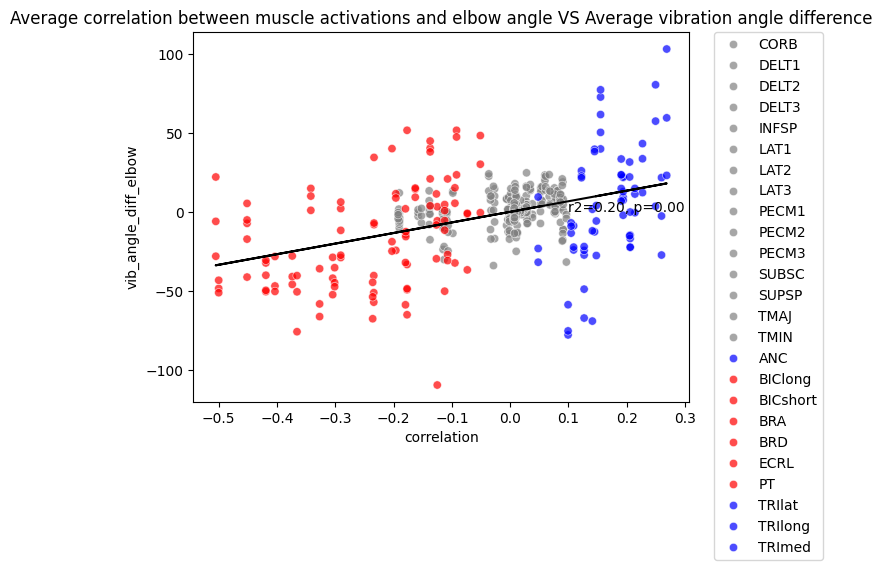

In [20]:
# Make a scatter plot where the x-axis is the correlation, the y-axis is the vib_angle_diff_elbow and the color is the muscle
import seaborn as sns

# Color the scatter plot based on the colormap
correlation_mean["color"] = correlation_mean["muscle"].map(COLORMAP)
sns.scatterplot(data=correlation_mean, 
                x="correlation", 
                y="vib_angle_diff_elbow", 
                hue="muscle",
                palette=COLORMAP,
                alpha=0.7)
# Calculate r2 and p-value and plot the linear regression line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(correlation_mean["correlation"], correlation_mean["vib_angle_diff_elbow"])
plt.plot(correlation_mean["correlation"], slope * correlation_mean["correlation"] + intercept, color="black")
plt.text(0.1, 0.1, f"r2={r_value**2:.2f}, p={p_value:.2f}")
print(f"r2={r_value**2}, p={p_value}")
print(intercept, slope)

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Average correlation between muscle activations and elbow angle VS Average vibration angle difference")
plt.show()

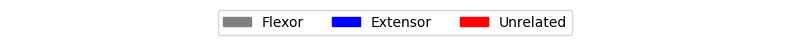

In [21]:
from matplotlib import patches as mpatches

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 0.5))

# Create the circular patches for the legend
flex_patch = mpatches.Circle((0.5, 0.5), 0.1, color='gray', label='Flexor')
ext_patch = mpatches.Circle((1.5, 0.5), 0.1, color='blue', label='Extensor')
unrel_patch = mpatches.Circle((2.5, 0.5), 0.1, color='red', label='Unrelated')

# Create the legend with horizontal layout
ax.legend(handles=[flex_patch, ext_patch, unrel_patch], loc='center', ncol=3)

# Hide the axis
ax.axis('off')

plt.tight_layout()
plt.show()